In [20]:
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier

In [21]:
df = pd.read_csv('cleaned_data.csv')

In [22]:
df

,sms,label
0,ذهاب جورونج نقط مجنو استفاد بوج عالم عظيم بوف سينم حصل امور وات,0
1,طيب نكت لار,0
2,دخول مجا ٢ كاس اتحاد نهاء ٢1 ٢005 871٢1 0845٢81007518,1
3,اقول وقت مبكر هور,0
4,ناه اعتقد جو اوسف عيش حول رغم,0
...,...,...
5108,مر ٢ اتصل ٧٥٠ جايز ٢ مطالب 087١87٢7٢008 ١ ١0 لكل دقيق,1
5109,ü اذهب متنزه منزل,0
5110,يقترح,0
5111,رجل كلب يتصرف معرف فايد شراء اسبوع قادم اعط مجا,0


In [23]:
pd.set_option('display.max_colwidth', None)


In [24]:
def tfidf_features(X_train, X_test, vectorizer_path):
    """Performs TF-IDF transformation and dumps the model."""
    
    # Train a vectorizer on X_train data.
    # Transform X_train and X_test data.
    
    # Pickle the trained vectorizer to 'vectorizer_path'
    # Don't forget to open the file in writing bytes mode.
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2), token_pattern='(\S+)')
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
        
    return X_train, X_test

In [25]:
print(f"the dataframe shape: {df.shape}")
df.head()

the dataframe shape: (5113, 2)


,sms,label
0,ذهاب جورونج نقط مجنو استفاد بوج عالم عظيم بوف سينم حصل امور وات,0
1,طيب نكت لار,0
2,دخول مجا ٢ كاس اتحاد نهاء ٢1 ٢005 871٢1 0845٢81007518,1
3,اقول وقت مبكر هور,0
4,ناه اعتقد جو اوسف عيش حول رغم,0


Number of dialect classes: 2


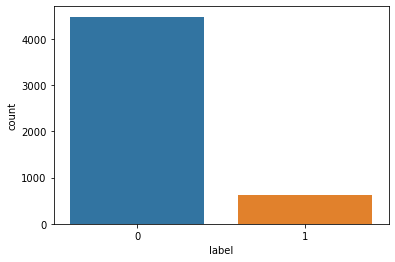

In [26]:
counts = df.label.value_counts()
print(f"Number of dialect classes: {df.label.nunique()}")
counts_df = pd.DataFrame(counts.to_dict().items(), columns=["label", "count"])
sns.barplot(data = counts_df, x="label", y="count", order=counts_df['label']);

In [27]:
X = df["sms"].values.astype('U') # You need to convert the dtype object to unicode for using tfidf_vectorizer
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify= y) ######### YOUR CODE HERE ##########
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))

X_train_tfidf, X_test_tfidf = tfidf_features(X_train, X_test, "Models/tfidf_vectorizer.pkl")

Train size = 3067, test size = 2046


In [32]:
(unique, counts) = np.unique(y_train, return_counts=True)
#cw_dict = dict(zip(unique, np.around(1/counts *counts.max(),3)))

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))
print(class_weight)

#class_weight = cw_dict
print(class_weight)

{0: 0.5702863518036445, 1: 4.056878306878307}
{0: 0.5702863518036445, 1: 4.056878306878307}


In [33]:
def plot_saveResults(model, modelname, X_train_tfidf, X_test_tfidf, y_train, y_test):
    print(f"-------------------------- [{modelname}] --------------------------")
    # check train accuracy
    y_train_pred = model.predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Train accuracy = {}'.format(train_accuracy))

    # Check test accuracy.
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Test accuracy = {}'.format(test_accuracy))

    ## Show results
    list_names = list(model.classes_)
    print(classification_report(y_test, y_test_pred))
    
    fig, ax = plt.subplots(1,2,figsize= (30,15))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[0]);
    ax[0].set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[0].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[0].set_ylabel('Actual dialect',font ={'weight' : 'bold'})

    ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred ,normalize ='true' ), display_labels=list_names).plot(ax=ax[1]);
    ax[1].set_title(f"[{modelname}]Train Confusion Matrix\nf1_score: {f1_score(y_train, y_train_pred, average='micro')}",font ={'weight' : 'bold'})
    ax[1].set_xlabel('Predictions dialect',font ={'weight' : 'bold'})
    ax[1].set_ylabel('Actual dialect',font ={'weight' : 'bold'})
    plt.savefig("Models/"+modelname+'_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    with open("Models/"+ modelname + ".pkl", 'wb') as f:
        pickle.dump(model, f)

-------------------------- [Logistic] --------------------------
Train accuracy = 0.9621780241278122
Test accuracy = 0.9340175953079178
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1794
           1       0.69      0.84      0.76       252

    accuracy                           0.93      2046
   macro avg       0.83      0.89      0.86      2046
weighted avg       0.94      0.93      0.94      2046



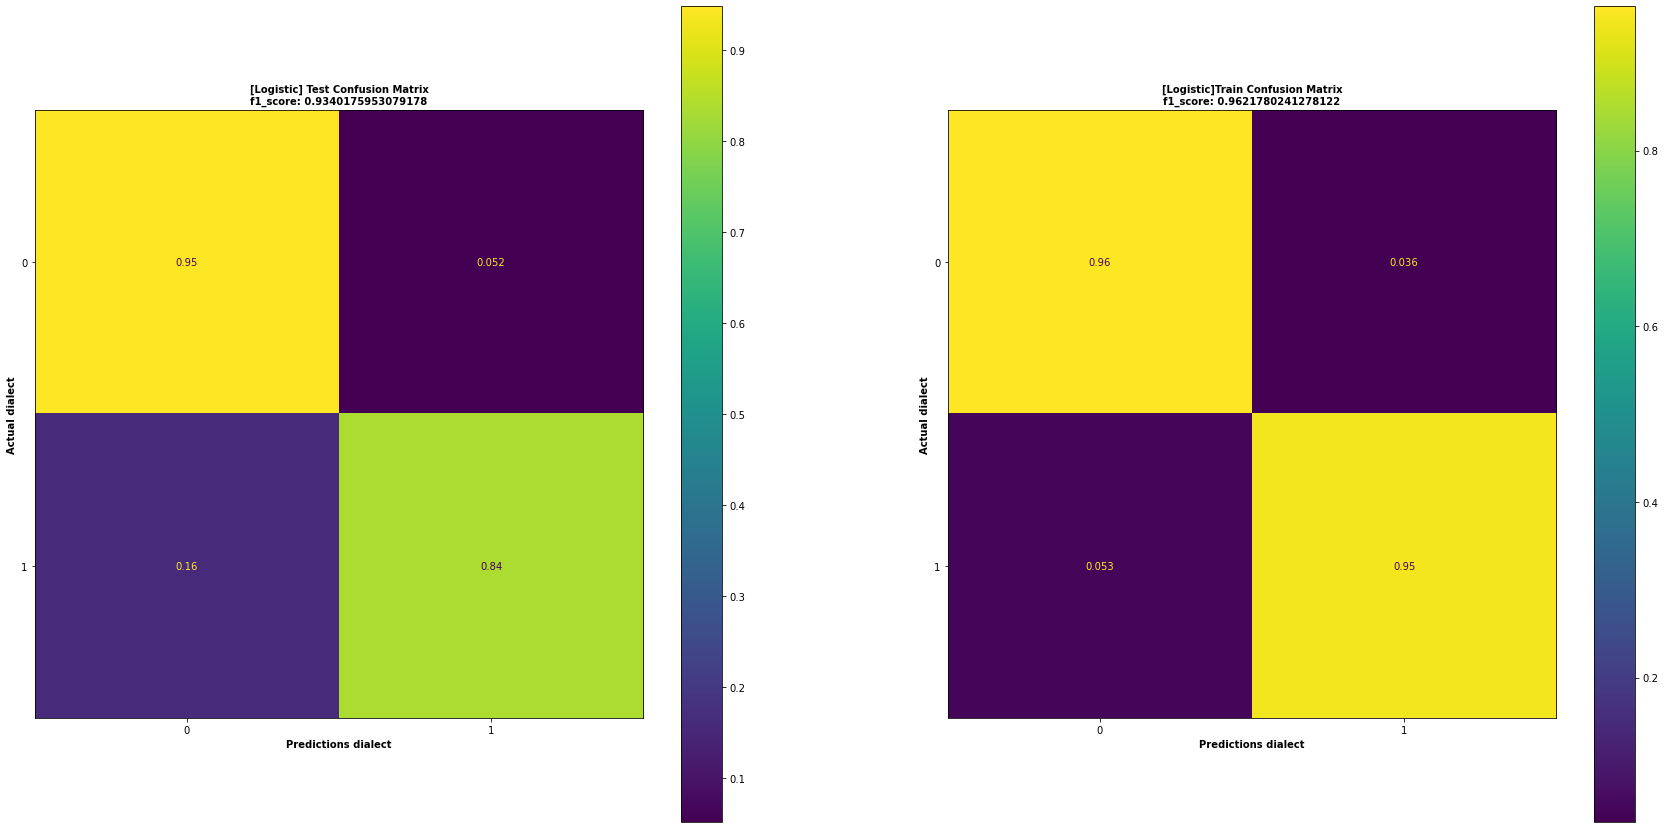

In [34]:
dialect_recognizer = LogisticRegression(penalty='l2', C=1, random_state=0, solver='liblinear', class_weight= class_weight)
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer,"Logistic", X_train_tfidf, X_test_tfidf, y_train, y_test)

-------------------------- [ComplementNaiveBayes] --------------------------
Train accuracy = 0.9178350179328334
Test accuracy = 0.8949169110459433
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1794
           1       0.54      0.90      0.68       252

    accuracy                           0.89      2046
   macro avg       0.76      0.90      0.81      2046
weighted avg       0.93      0.89      0.91      2046



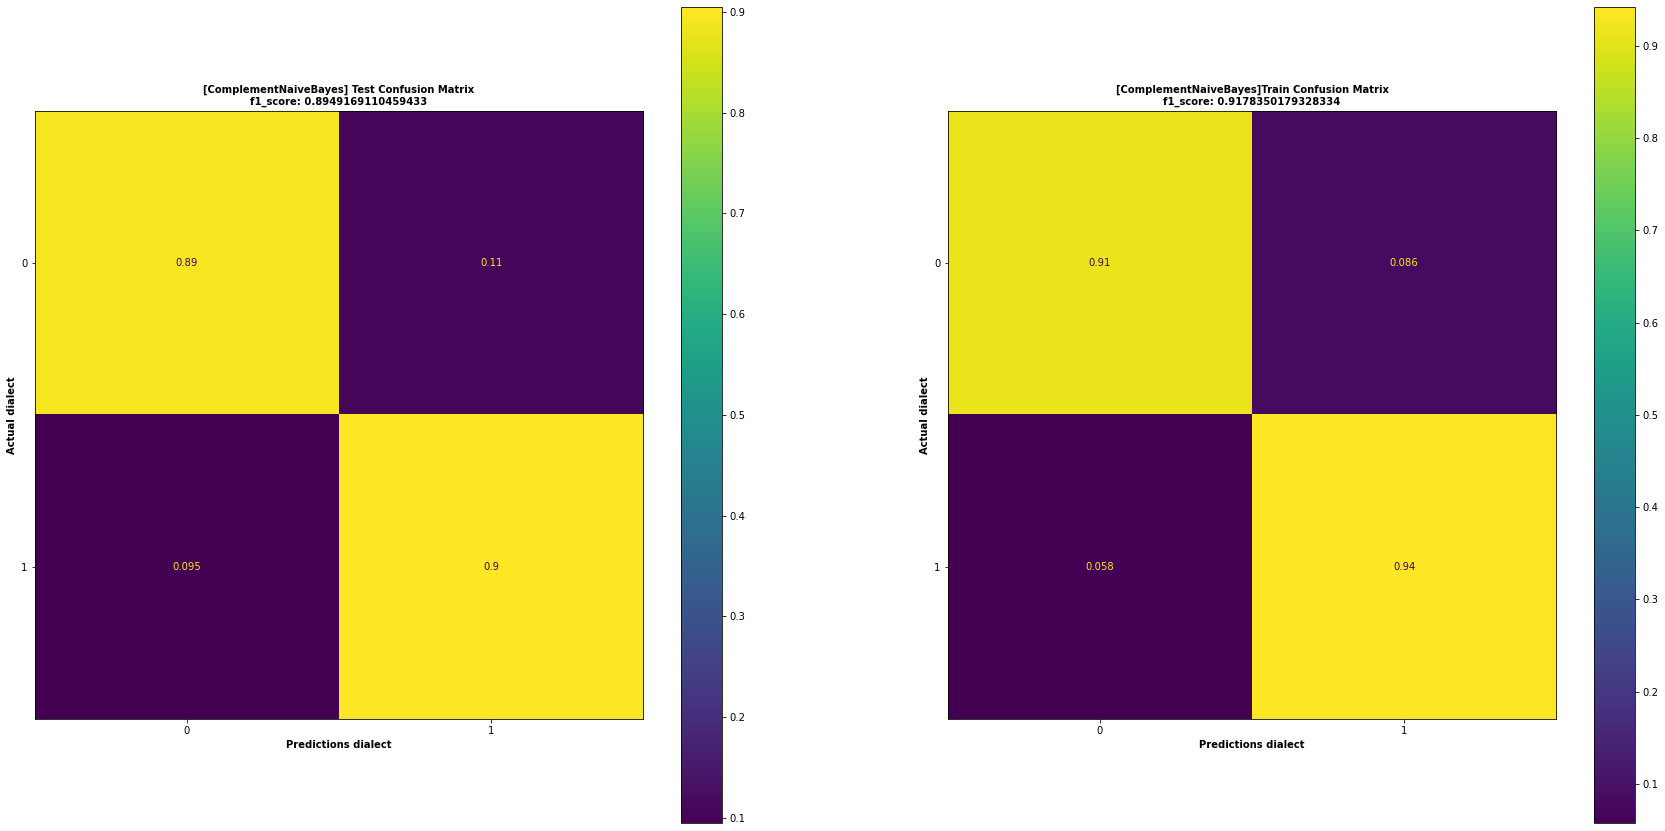

In [35]:
dialect_recognizer = ComplementNB()
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer, "ComplementNaiveBayes", X_train_tfidf, X_test_tfidf, y_train, y_test)

-------------------------- [SGDClassifier] --------------------------
Train accuracy = 0.9677208999021846
Test accuracy = 0.9296187683284457
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1794
           1       0.68      0.81      0.74       252

    accuracy                           0.93      2046
   macro avg       0.83      0.88      0.85      2046
weighted avg       0.94      0.93      0.93      2046



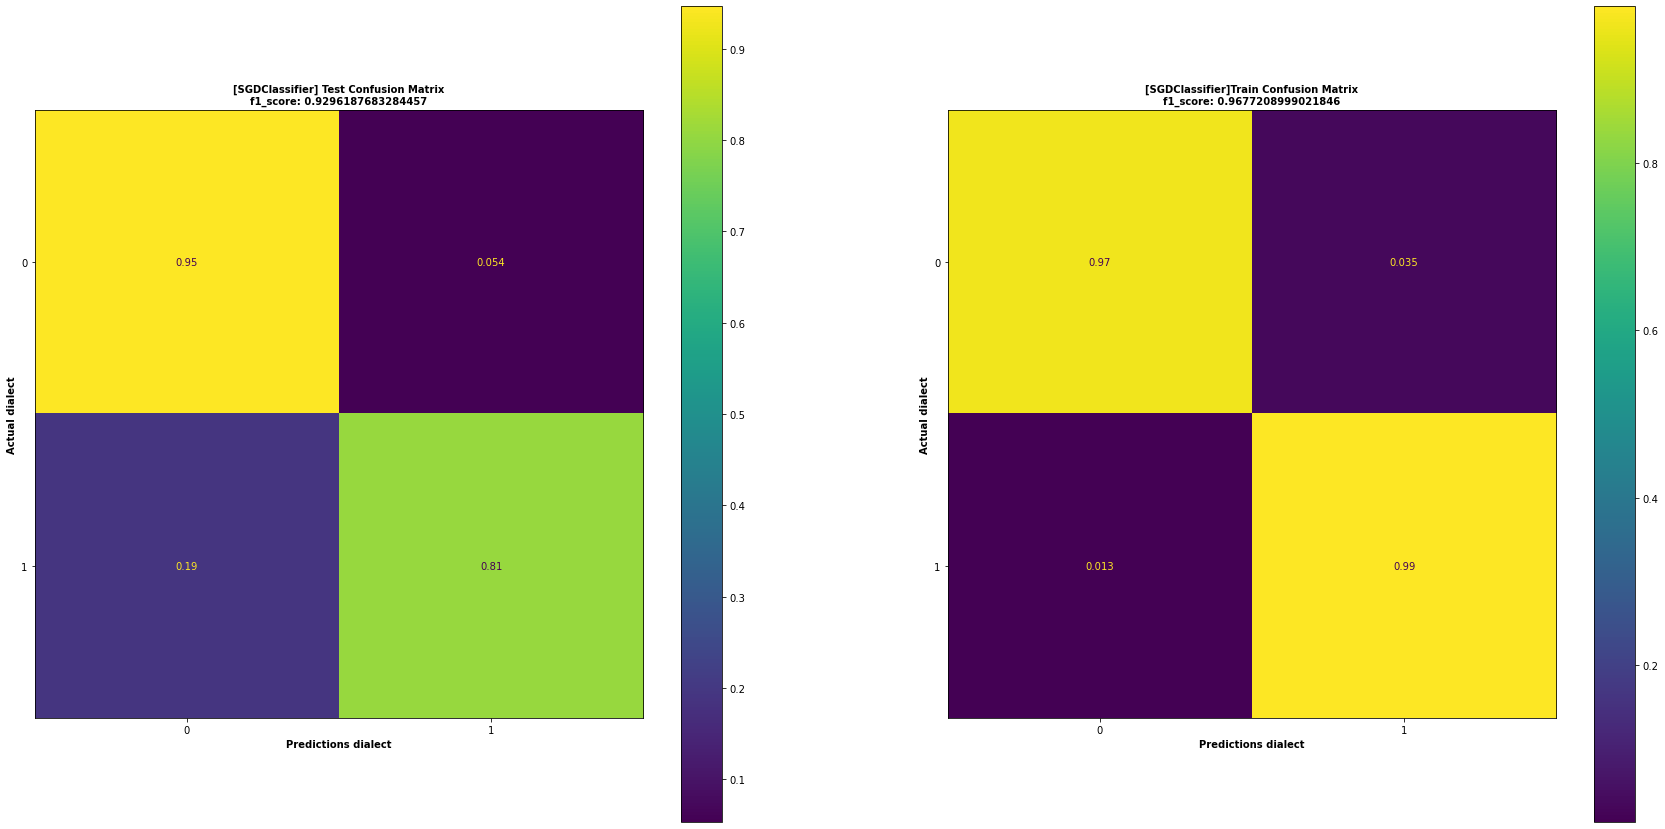

In [36]:
dialect_recognizer = SGDClassifier(loss='hinge', n_jobs=-1, class_weight= class_weight)
dialect_recognizer.fit(X_train_tfidf, y_train)

plot_saveResults(dialect_recognizer, "SGDClassifier", X_train_tfidf, X_test_tfidf, y_train, y_test)

In [37]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

dialect_recognizer = SGDClassifier(loss='hinge', n_jobs=-1, class_weight= class_weight)
dialect_recognizer.fit(X_train_tfidf, y_train)

y_pred_train = dialect_recognizer.predict(X_train_tfidf)
y_pred_test = dialect_recognizer.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')

train_auc_roc = roc_auc_score(y_train, y_pred_train)
test_auc_roc = roc_auc_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Training precision:", train_precision)
print("Testing precision:", test_precision)
print("Training recall:", train_recall)
print("Testing recall:", test_recall)
print("Training F1-score:", train_f1)
print("Testing F1-score:", test_f1)
print("Training AUC-ROC score:", train_auc_roc)
print("Testing AUC-ROC score:", test_auc_roc)


Training accuracy: 0.9700032605151614
Testing accuracy: 0.9320625610948191
Training precision: 0.975008616485402
Testing precision: 0.9376577816653713
Training recall: 0.9700032605151614
Testing recall: 0.9320625610948191
Training F1-score: 0.9712386559073609
Testing F1-score: 0.9342253594423896
Training AUC-ROC score: 0.9772092259076268
Testing AUC-ROC score: 0.877694165737644
